In [1]:
# 量子振幅推定の量子回路を構築するソースコード
# 必要なモジュールをインポートする
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer
from qiskit.tools.visualization import plot_histogram
import numpy as np

In [2]:
# 各量子レジスタを用意する。
qr_amp = QuantumRegister(2, name='amp')
qr_qft = QuantumRegister(2, name='qft')
c_ans = ClassicalRegister(2, name='ans')
# 量子回路を生成する。
circuit = QuantumCircuit(qr_amp, qr_qft, c_ans)



In [5]:
# 振幅増幅関数
def cq(circuit, amp, c):
    qr_cq = QuantumRegister(3)
    circuit_cq = QuantumCircuit(qr_cq, name='$C\mathcal{Q}$')

    # UΨ_0
    circuit_cq.cx(2,0)
    circuit_cq.cz(2,0)
    circuit_cq.cz(2,1)
    circuit_cq.cx(2,0)

    # UΨ
    circuit_cq.ccx(2,1,0)
    circuit_cq.ch(2,1)
    circuit_cq.cry(-2*np.pi/3, 2, 0)

    circuit_cq.cx(2, 0)
    circuit_cq.cx(2, 1)

    circuit_cq.h(1)
    circuit_cq.ccx(2, 0, 1)
    circuit_cq.h(1)

    circuit_cq.cx(2, 1)
    circuit_cq.cx(2, 0)

    circuit_cq.cry(2*np.pi/3, 2, 0)
    circuit_cq.ch(2, 1)
    circuit_cq.ccx(2, 1, 0)

    sub_inst = circuit_cq.to_instruction()
    circuit.append(sub_inst, [amp[0], amp[1], c])

In [6]:
# 初期状態 A
circuit.ry(2*np.pi/3, 0)
circuit.h(1)
circuit.cx(1,0)

circuit.barrier(qr_amp)

# 初期化
circuit.h(qr_qft)

# 振幅増幅
cq(circuit, qr_amp, qr_qft[0])

for i in range(2):
    cq(circuit, qr_amp, qr_qft[1])

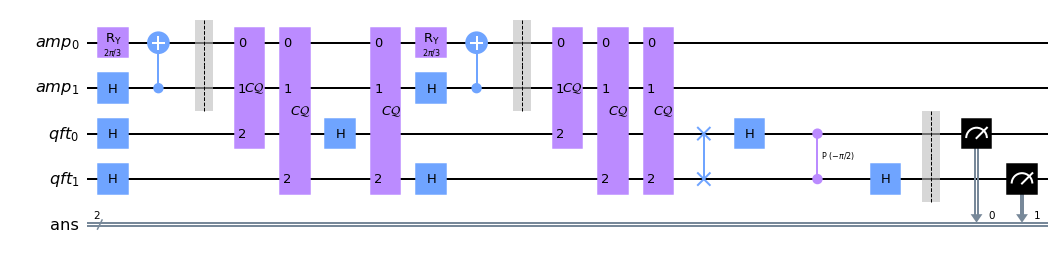

In [7]:
# 逆量子フーリエ変換
circuit.swap(qr_qft[0], qr_qft[1])
circuit.h(qr_qft[0])
circuit.cp(-np.pi/2,qr_qft[0],qr_qft[1])
circuit.h(qr_qft[1])

circuit.barrier(qr_qft)
# 測定する。
circuit.measure(qr_qft, c_ans)
# 量子回路を描画する。
circuit.draw(output='mpl', fold=50)

In [8]:
# マシンを選択して実行する。
backend = Aer.get_backend('qasm_simulator')
shots = 1000
results = execute(circuit, backend=backend, shots=shots).result()
answer = results.get_counts()


{'01': 157, '11': 160, '00': 587, '10': 96}


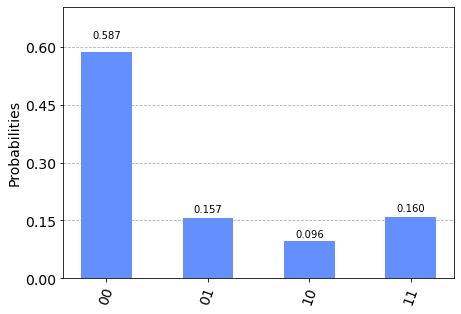

In [9]:
print(answer)
plot_histogram(answer)